### LSTM model
* Split test and train data
* Get some insights
* Train the model

Import libraries

In [1]:
import pandas as pd

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import TensorBoard

import tensorflow as tf


from math import sqrt
from numpy import concatenate

2023-01-15 14:48:35.477997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 14:48:36.875982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-15 14:48:36.876112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-15 14:48:36.876118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
tf.config.run_functions_eagerly(True)

Defining functions

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Load data

In [26]:
df = pd.read_parquet("../data/processed/new-avc.parquert")
df.head()

,date,co_ppb,o3_ppb,pm25_ugm3,so2_ugm3,temperatura_c,umidade_relativa_percentual,precipitacao_mmdia,focos_queimada,respiratory,avc
0,2013-01-01,135.40,11.125,8.175,0.875,26.450,81.75,2.0,0.0,6.0,1.0
1,2013-01-02,155.05,10.925,11.675,1.000,26.400,82.00,2.0,0.0,8.0,0.0
2,2013-01-03,137.40,12.225,8.800,0.825,27.400,81.25,0.0,0.0,12.0,1.0
3,2013-01-04,128.30,13.750,11.650,0.925,27.750,76.25,1.0,0.0,9.0,0.0
4,2013-01-05,128.25,10.950,7.800,1.075,26.625,84.75,9.0,0.0,10.0,1.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 0 to 2190
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         2191 non-null   datetime64[ns]
 1   co_ppb                       2191 non-null   float64       
 2   o3_ppb                       2191 non-null   float64       
 3   pm25_ugm3                    2191 non-null   float64       
 4   so2_ugm3                     2191 non-null   float64       
 5   temperatura_c                2191 non-null   float64       
 6   umidade_relativa_percentual  2191 non-null   float64       
 7   precipitacao_mmdia           2191 non-null   float64       
 8   focos_queimada               2191 non-null   float64       
 9   respiratory                  2191 non-null   float64       
 10  avc                          2191 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory us

In [28]:
df = df.set_index("date")
df.head()

,co_ppb,o3_ppb,pm25_ugm3,so2_ugm3,temperatura_c,umidade_relativa_percentual,precipitacao_mmdia,focos_queimada,respiratory,avc
date,,,,,,,,,,
2013-01-01,135.40,11.125,8.175,0.875,26.450,81.75,2.0,0.0,6.0,1.0
2013-01-02,155.05,10.925,11.675,1.000,26.400,82.00,2.0,0.0,8.0,0.0
2013-01-03,137.40,12.225,8.800,0.825,27.400,81.25,0.0,0.0,12.0,1.0
2013-01-04,128.30,13.750,11.650,0.925,27.750,76.25,1.0,0.0,9.0,0.0
2013-01-05,128.25,10.950,7.800,1.075,26.625,84.75,9.0,0.0,10.0,1.0


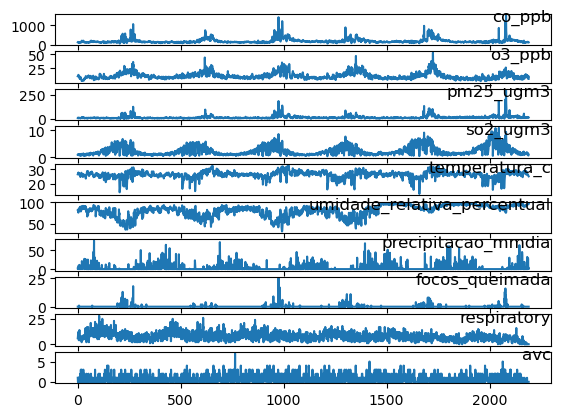

In [29]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(df.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

Normalize features

In [30]:
df = df.drop(columns=["avc"])

In [31]:
values = df.values

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Apply series_to_supervised

In [33]:
n_lags = 3

In [41]:
df_sl = series_to_supervised(scaled, n_lags, 1)

Drop columns I don't want to predict

In [42]:
df_sl.drop(df_sl.columns[[27, 28, 29, 30, 31, 32, 33, 34]], axis=1, inplace=True)

In [43]:
df_sl.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var1(t-2),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var9(t)
3,0.046447,0.170392,0.025462,0.056471,0.687109,0.746212,0.026667,0.0,0.214286,0.060167,...,0.047843,0.192250,0.027563,0.051765,0.734668,0.738636,0.000000,0.00,0.428571,0.321429
4,0.060167,0.166418,0.037227,0.068235,0.684606,0.750000,0.026667,0.0,0.285714,0.047843,...,0.041490,0.222553,0.037143,0.061176,0.752190,0.662879,0.013333,0.00,0.321429,0.357143
5,0.047843,0.192250,0.027563,0.051765,0.734668,0.738636,0.000000,0.0,0.428571,0.041490,...,0.041455,0.166915,0.024202,0.075294,0.695870,0.791667,0.120000,0.00,0.357143,0.142857
6,0.041490,0.222553,0.037143,0.061176,0.752190,0.662879,0.013333,0.0,0.321429,0.041455,...,0.028696,0.176354,0.017563,0.047059,0.720901,0.772727,0.013333,0.00,0.142857,0.214286
7,0.041455,0.166915,0.024202,0.075294,0.695870,0.791667,0.120000,0.0,0.357143,0.028696,...,0.039675,0.162444,0.018655,0.040000,0.732165,0.791667,0.000000,0.04,0.214286,0.250000


Define and fit model

Split into train and test sets

In [44]:
values = df_sl.values
train_set, test_set = train_test_split(
    df_sl, test_size=0.2, shuffle=False
)

In [45]:
train_X, train_Y = train_set.drop("var9(t)", axis=1), train_set.drop(train_set.columns[:27], axis=1)
test_X, test_Y = test_set.drop("var9(t)", axis=1), test_set.drop(test_set.columns[:27], axis=1)

Reshape input to be 3D [samples, timesteps, features]

In [46]:
train_x, test_x = train_X.values, test_X.values
train_y, test_y = train_Y.values, test_Y.values

In [47]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Design network

In [48]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


Fit network

In [49]:
history = model.fit(train_x, train_y, epochs=50, batch_size=72,
    validation_data=(test_x, test_y), verbose=2, shuffle=False, callbacks=[TensorBoard(log_dir="logs/LSTM")])

Epoch 1/50


/home/matheus/miniconda3/envs/tg/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 - 1s - loss: 0.1437 - val_loss: 0.1492 - 747ms/epoch - 30ms/step
Epoch 2/50
25/25 - 1s - loss: 0.1154 - val_loss: 0.1281 - 683ms/epoch - 27ms/step
Epoch 3/50
25/25 - 1s - loss: 0.1136 - val_loss: 0.1233 - 692ms/epoch - 28ms/step
Epoch 4/50
25/25 - 1s - loss: 0.1128 - val_loss: 0.1217 - 701ms/epoch - 28ms/step
Epoch 5/50
25/25 - 1s - loss: 0.1109 - val_loss: 0.1145 - 685ms/epoch - 27ms/step
Epoch 6/50
25/25 - 1s - loss: 0.1104 - val_loss: 0.1116 - 682ms/epoch - 27ms/step
Epoch 7/50
25/25 - 1s - loss: 0.1093 - val_loss: 0.1079 - 692ms/epoch - 28ms/step
Epoch 8/50
25/25 - 1s - loss: 0.1082 - val_loss: 0.1039 - 672ms/epoch - 27ms/step
Epoch 9/50
25/25 - 1s - loss: 0.1076 - val_loss: 0.1012 - 679ms/epoch - 27ms/step
Epoch 10/50
25/25 - 1s - loss: 0.1071 - val_loss: 0.0988 - 668ms/epoch - 27ms/step
Epoch 11/50
25/25 - 1s - loss: 0.1069 - val_loss: 0.0976 - 682ms/epoch - 27ms/step
Epoch 12/50
25/25 - 1s - loss: 0.1065 - val_loss: 0.0956 - 671ms/epoch - 27ms/step
Epoch 13/50
25/25 - 1s -

Plot history

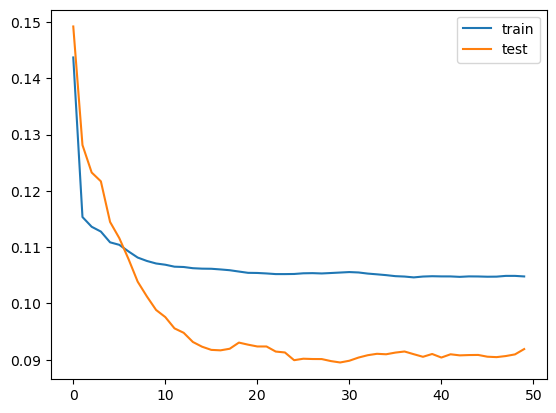

In [50]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [51]:
# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))

14/14 [==============================] - 0s 7ms/step


/home/matheus/miniconda3/envs/tg/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [55]:
# invert scaling for forecast
inv_yhat = concatenate((test_x[:, -8:], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,8]

In [56]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_x[:, -8:], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,8]

In [57]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.080
